Counterfactual simulation model for government interventions
-------------------------------------------------------------------------

RNN-based approach to simulate the effect of timing and taking action on deaths-per-100k inhabitants.

In [1]:
import datetime
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
tf.__version__

'2.1.0'

In [3]:
pd.options.display.max_colwidth = 200
pd.options.display.max_columns = 100

#### Data sources

* The countermeasures data is made available as part of the John Hopkins [Containment Measures Database](http://epidemicforecasting.org/containment).
* The Oxford COVID-19 Government Response Tracker is made available as part of the [OxCGRT](https://www.bsg.ox.ac.uk/research/research-projects/oxford-covid-19-government-response-tracker) project.
* The population data was gathered from the [Word Bank Databank](https://databank.worldbank.org/reports.aspx?source=2&series=SP.POP.TOTL&country=#). The latest data available in the World Bank data catalogue is for 2018.

In [4]:
johnshopkins_df = pd.read_csv("data/countermeasures_db_johnshopkins_2020_03_30.csv")
johnshopkins_df["Date"] = johnshopkins_df["Date"].apply(lambda x: pd.to_datetime(x, format="%Y-%m-%d")).dt.date

In [5]:
oxford_grt_df = pd.read_csv("data/oxford_uni_response_tracker_08042020.csv")
oxford_grt_df["Date"] = oxford_grt_df["Date"].apply(lambda x: pd.to_datetime(str(x), format="%Y-%m-%d")).dt.date

In [6]:
grt_df = oxford_grt_df.drop_duplicates(subset=["CountryName", "StringencyIndex"], keep="first")

In [7]:
# measures_df = pd.merge(johnshopkins_df, grt_df, how="outer", left_on=["Date", "Country"], 
#                        right_on=["Date", "CountryName"])
measures_df = johnshopkins_df

Preprocess the World Bank population statistics:

* Total country population in 2018
* GDP per capita in 2018
* Percentage of the population aged 65 or above in 2018
* Population density in 2018

In [8]:
wb_df = pd.read_csv("data/wb_population_data.csv")[["Series Name", "Country Name", "2018 [YR2018]"]]
wb_df.rename(columns={"2018 [YR2018]": "2018"}, inplace=True)
wb_df = wb_df.replace("NA", 0.0)
wb_df = wb_df[wb_df["Country Name"].notna()]

In [9]:
population_df = wb_df[wb_df["Series Name"] == "Population, total"]
population_df = population_df[["Country Name", "2018"]]
population_df.rename(columns={"2018": "2018_country_population"}, inplace=True)

In [10]:
gdp_df = wb_df[wb_df["Series Name"] == "GDP per capita (constant 2010 US$)"]

scaler_0 = MinMaxScaler()
scaled_gdp_per_capita = scaler_0.fit_transform(gdp_df[["2018"]].values)

gdp_df["2018_gdp_per_capita"] = scaled_gdp_per_capita
gdp_df = gdp_df[["Country Name", "2018_gdp_per_capita"]]

/Users/braadbaart/pysphere/covid/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [11]:
elderly_df = wb_df[wb_df["Series Name"] == "Population ages 65 and above (% of total population)"]

scaler_1 = MinMaxScaler()
scaled_percentages = scaler_1.fit_transform(elderly_df[["2018"]].values)

elderly_df["2018_elderly_percentage"] = scaled_percentages
elderly_df = elderly_df[["Country Name", "2018_elderly_percentage"]]

/Users/braadbaart/pysphere/covid/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [12]:
pop_density_df = wb_df[wb_df["Series Name"] == "Population density (people per sq. km of land area)"]

scaler_2 = MinMaxScaler()
scaled_density = scaler_2.fit_transform(pop_density_df[["2018"]].values)

pop_density_df["2018_population_density"] = scaled_density
pop_density_df = pop_density_df[["Country Name", "2018_population_density"]]

/Users/braadbaart/pysphere/covid/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Merge the World Bank population and countermeasures data

In [13]:
master_df = pd.merge(measures_df, population_df, how="outer", left_on="Country", right_on="Country Name")
master_df = pd.merge(master_df, gdp_df, how="outer", on="Country Name")
master_df = pd.merge(master_df, elderly_df, how="outer", on="Country Name")
master_df = pd.merge(master_df, pop_density_df, how="outer", on="Country Name")

In [14]:
base_df = master_df.dropna(subset=["Country"])
base_df = base_df.fillna(0)

In [15]:
print(base_df["Country"].unique())

['Austria' 'Germany' 'United Kingdom' 'Vietnam' 'South Korea' 'Taiwan'
 'Macau' 'Hong Kong' 'Czechia' 'Slovakia' 'Iran' 'Russia' 'Egypt'
 'Kyrgyzstan' 'Singapore' 'Israel' 'Japan' 'Sweden' 'San Marino'
 'Slovenia' 'Canada' 'China' 'Thailand' 'Italy' 'Australia'
 'Trinidad and Tobago' 'Qatar' 'New Zealand' 'Colombia' 'Romania' 'France'
 'Portugal' 'Spain' 'Belgium' 'Luxembourg' 'Albania' 'Andorra'
 'Azerbaijan' 'Belarus' 'Bosnia and Herzegovina' 'Bulgaria' 'Denmark'
 'Estonia' 'Cyprus' 'Croatia' 'Finland' 'Georgia' 'Hungary' 'Latvia'
 'Lithuania' 'Greece' 'Moldova' 'Malta' 'Monaco' 'Netherlands' 'Iceland'
 'Ireland' 'Kosovo' 'Kazakhstan' 'Poland' 'Turkey' 'Ukraine' 'Serbia'
 'Switzerland' 'Norway' 'Montenegro' 'Liechtenstein' 'Mexico' 'Malaysia'
 'Nepal' 'Afghanistan' 'Iraq' 'Philippines' 'Kuwait' 'South Africa'
 'Armenia' 'Pakistan' 'Brazil' 'Costa Rica' 'Panama' 'India' 'Bahrain'
 'United Arab Emirates' 'Indonesia' 'Namibia' 'Uganda']


In [16]:
other_cm_cols = ['Unnamed: 0', 'Resumption', 'Diagnostic criteria tightened', 'Diagnostic criteria loosened',
                 'Testing criteria', 'Country Name', 'CountryName', 'CountryCode', 'ConfirmedCases', '2018',
                 'ConfirmedDeaths', 'StringencyIndex', 'StringencyIndexForDisplay', 'Unnamed: 39', 'Country Name',
                 'Series Name']

In [17]:
metadata = ["Date", "Country", "Confirmed Cases", "Deaths", "2018_country_population"]

In [18]:
country_features = ["2018_gdp_per_capita", "2018_elderly_percentage", "2018_population_density"]

In [19]:
countermeasures = list(filter(lambda m: m not in other_cm_cols and m not in metadata and m not in country_features
                              and not m.endswith("_Notes") and not m.endswith("_IsGeneral"), base_df.columns))

In [20]:
df = base_df[metadata + country_features + countermeasures].fillna(0)

In [21]:
df[countermeasures] = df[countermeasures].mask(df[countermeasures] > 0, 1.0)

In [22]:
countermeasures

['Symptomatic isolation - targeted',
 'Symptomatic isolation - blanket',
 'Asymptomatic isolation - targeted',
 'Asymptomatic isolation - blanket',
 'Domestic travel restriction',
 'International travel restriction',
 'Testing',
 'Contact tracing',
 'Mask wearing',
 'Hand washing',
 'Gatherings banned',
 'Healthcare specialisation',
 'Public education and incentives',
 'Assisting people to stay home',
 'Public cleaning',
 'Miscellaneous hygiene measures',
 'Public interaction reduction',
 'Nonessential business suspension',
 'School closure',
 'Activity cancellation']

## Simulation of the effect and timing of countermeasures

Exploration of the impact of government countermeasures on reported Deaths per 100.000 citizens in a single country:

* The [counterfactual intervention](#Intervention) (the package of measures described below) is compared to the actual mortality rates.
* The [model weights](#Simulation-model) are learnt from the relation between countermeasures and mortality for all the other countries in the dataset.

The [simulation itself](#Run-the-simulation) consists generating mortality predictions using partially counterfactual data and the model trained on 100% real (observed) data.

#### Model parameters

In [23]:
params = {
    "sequence_length": 4,
    "batch_size": 16,
    "num_epochs": 50,
    "cell_units": 64,
    "mlp_cells": 256,
    "dropout_rate": 0.4
}

In [24]:
train_validation_split = 0.85

#### Simulation parameters

In [25]:
country = "Germany"
package = ["Asymptomatic isolation - blanket", "Gatherings banned", "Public interaction reduction", 
           "Nonessential business suspension", "School closure"]
treatment_start = 7 # Counterfactual start date of intervention in days after first reported case

#### Preprocess the simulation data

In the simulation data, the counterfactual treatment condition is coded '1.0' starting $n$ days after the first reported case of COVID-19 in the country.

In [26]:
def create_simulation_data(df, country, simulated_measures, treatment_start, measures, seq_length):
    
    # Simulation parameters
    sim_df = df[df["Country"] == country].sort_values(by="Date")
    date_first_reported_case = sim_df.loc[sim_df["Confirmed Cases"].ne(0.0).idxmax():, ["Date"]].values[0][0]
    counterfactual_start_date = date_first_reported_case + datetime.timedelta(days=treatment_start)
    
    # Simulation counterfactuals
    for countermeasure in simulated_measures:
        actual_start_date = sim_df.loc[sim_df[countermeasure].idxmax(1.0):, ["Date"]].values[0][0]
        difference_in_days = (actual_start_date - counterfactual_start_date).days
        sim_df.loc[sim_df.index[sim_df["Date"] == counterfactual_start_date].values[0]:, countermeasure] = 1.0
        
        print(f"Setting counterfactual start date for treatment '{countermeasure}' to {str(counterfactual_start_date)}.")
        print(f"Actual start date of treatment '{countermeasure}': {str(actual_start_date)}.")
        print(f"Intervention in simulation occurs {difference_in_days} days prior to intervention in real life.")
        print("\n")
        
    sim_df[["Reported Deaths", "Reported Cases"]] = sim_df[["Deaths", "Confirmed Cases"]].diff()
    sim_df["Mortality_per_100k"] = sim_df["Reported Deaths"] / (
        sim_df["2018_country_population"].astype(float) / 100000.0)
    sim_df["Cases_per_100k"] = sim_df["Reported Cases"] / (
        sim_df["2018_country_population"].astype(float) / 100000.0)
    sim_df = sim_df.fillna(0)
    sim_df["DateIndex"] = sim_df["Date"]
    sim_df = sim_df.set_index("DateIndex")
    
    # Prepare data for model input
    sim_label_df = sim_df["Mortality_per_100k"]
    sim_features_df = sim_df[measures + ["Cases_per_100k"] + country_features]
    
    sim_features = []
    sim_labels = []

    for i in range(int(len(sim_df) - seq_length)):
        sim_labels.append(sim_label_df[i + seq_length])
        sim_features.append(sim_features_df[i: (i + seq_length)].values)
    
    X = np.asarray(sim_features)
    y = np.asarray(sim_labels)
    y = y.reshape((y.shape[0], 1))
    
    return sim_df, X, y, counterfactual_start_date

#### Intervention

In [27]:
simulation_df, sim_X, sim_y, cf_start_date = create_simulation_data(df, country, package, treatment_start, 
                                                                    countermeasures, params["sequence_length"])

Setting counterfactual start date for treatment 'Asymptomatic isolation - blanket' to 2020-02-03.
Actual start date of treatment 'Asymptomatic isolation - blanket': 2020-03-20.
Intervention in simulation occurs 46 days prior to intervention in real life.


Setting counterfactual start date for treatment 'Gatherings banned' to 2020-02-03.
Actual start date of treatment 'Gatherings banned': 2020-03-09.
Intervention in simulation occurs 35 days prior to intervention in real life.


Setting counterfactual start date for treatment 'Public interaction reduction' to 2020-02-03.
Actual start date of treatment 'Public interaction reduction': 2020-03-09.
Intervention in simulation occurs 35 days prior to intervention in real life.


Setting counterfactual start date for treatment 'Nonessential business suspension' to 2020-02-03.
Actual start date of treatment 'Nonessential business suspension': 2020-03-14.
Intervention in simulation occurs 40 days prior to intervention in real life.


Setting co

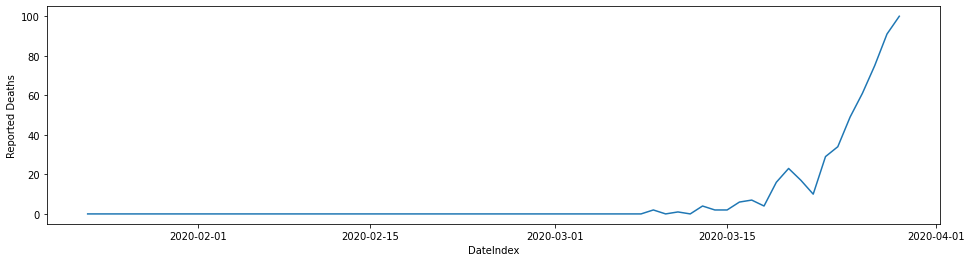

In [28]:
plt.figure(figsize=(16,4))
sns.lineplot(x=simulation_df.index, y="Reported Deaths", data=simulation_df)

In [29]:
record_start = simulation_df["Date"].head(1).values[0]
record_end = simulation_df["Date"].tail(1).values[0]
num_days = (record_end - record_start).days
num_deaths = simulation_df["Deaths"].tail(1).values[0]
print(f"Recorded {num_deaths} COVID-19 deaths from {str(record_start)} to {str(record_end)} ({num_days} days) in the factual data for {country}.")

Recorded 533.0 COVID-19 deaths from 2020-01-23 to 2020-03-29 (66 days) in the factual data for Germany.


#### Holdout data

The observed country data used to test the predictive performance of the model.

In [30]:
holdout_df, holdout_X, holdout_y, _ = create_simulation_data(df, country, [], 0, countermeasures, 
                                                             params["sequence_length"])

#### Preprocess the training and validation data

In the training data, actual observed mortality rates for COVID-19 all countries in the dataset is prepared as the dependent variable ($y$), with the countermeasures taken by national governments making up the features ($X$).

In [31]:
def create_train_and_validation_data(df, country, train_split, measures, seq_length):
    train_df = df[df["Country"] != country]
    train_countries = list(filter(lambda c: c != country, df["Country"].unique()))
    
    features = []
    labels = []
    
    # Retrieve the feature sequences and mortality data for each of the countries in the dataset
    for country in train_countries:
        country_df = train_df[train_df["Country"] == country].sort_values(by="Date")
        country_df[["Reported Deaths", "Reported Cases"]] = country_df[["Deaths", "Confirmed Cases"]].diff()
        country_df["Mortality_per_100k"] = country_df["Reported Deaths"] / (
            country_df["2018_country_population"].astype(float) / 100000.0)
        country_df["Cases_per_100k"] = country_df["Reported Cases"] / (
            country_df["2018_country_population"].astype(float) / 100000.0)
        country_df = country_df.replace([-np.inf, np.inf], np.nan)
        country_df = country_df.fillna(0)
        country_df = country_df.set_index("Date")
        
        country_label_df = country_df["Mortality_per_100k"]
        
        country_label_df.loc[country_label_df < 0.0] = 0.0
        country_features_df = country_df[measures + ["Cases_per_100k"] + country_features]
        
        for i in range(int(len(country_df) - seq_length)):
            labels.append(country_label_df[i + seq_length])
            features.append(country_features_df[i: (i + seq_length)].values)
    
    # Shuffle the data
    split_point = int(len(features) * train_split)
    data = list(zip(features, labels))
    random.shuffle(data)
    s_features, s_labels = zip(*data)
    
    # Prepare the data format for the model
    train_X = np.asarray(s_features[0:split_point])
    train_y = np.asarray(s_labels[0:split_point])
    train_y = train_y.reshape((train_y.shape[0], 1))

    val_X = np.asarray(s_features[split_point:len(features)])
    val_y = np.asarray(s_labels[split_point:len(labels)])
    val_y = val_y.reshape((val_y.shape[0], 1))
    
    return train_X, train_y, val_X, val_y

In [32]:
X, y, validation_X, validation_y = create_train_and_validation_data(df, country, train_validation_split, 
                                                                    countermeasures, params["sequence_length"])

/Users/braadbaart/pysphere/covid/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [33]:
print(f"Prepared {len(X)} training and {len(validation_X)} validation samples with feature dimensions {X.shape}.")

Prepared 4551 training and 804 validation samples with feature dimensions (4551, 4, 24).


In [34]:
pd.Series(y.T[0]).describe()

count    4551.000000
mean        0.026412
std         0.382178
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        17.759361
dtype: float64

In [35]:
pd.Series(validation_y.T[0]).describe()

count    804.000000
mean       0.028648
std        0.272800
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        5.919787
dtype: float64

### Simulation model

In [36]:
inputs = tf.keras.layers.Input(shape=(params["sequence_length"], len(countermeasures) + 1 + len(country_features)))
lstm_output, h, c = tf.keras.layers.LSTM(params["cell_units"], bias_initializer="random_uniform", 
                                         kernel_initializer="truncated_normal", return_state=True)(inputs)
dropout_1 = tf.keras.layers.Dropout(params["dropout_rate"])(lstm_output)
mlp = tf.keras.layers.Dense(params["mlp_cells"], activation="selu", kernel_initializer="he_normal",
                            kernel_regularizer=tf.keras.regularizers.l2(0.3))(dropout_1)
dropout_2 = tf.keras.layers.Dropout(params["dropout_rate"])(mlp)
output_layer = tf.keras.layers.Dense(1, activation="tanh")(dropout_2)

In [37]:
model = tf.keras.models.Model(inputs, output_layer, name="simulation_model")
model.compile(loss="mae", optimizer="adam", metrics=["mae", "mse"])

In [38]:
model.summary()

Model: "simulation_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4, 24)]           0         
_________________________________________________________________
lstm (LSTM)                  [(None, 64), (None, 64),  22784     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 256)               16640     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 39,681
Trainable params: 39,681
Non-trainable params: 0
______________________________________________

In [39]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="loss", mode="min", patience=2)

#### Train the model

In [40]:
train = model.fit(X, y, epochs=params["num_epochs"], batch_size=params["batch_size"], callbacks=[early_stopping], 
                  validation_data=(validation_X, validation_y))

Train on 4551 samples, validate on 804 samples
Epoch 1/50
4551/4551 [==============================] - 4s 888us/sample - loss: 52.7189 - mae: 0.0654 - mse: 0.1495 - val_loss: 9.1954 - val_mae: 0.0291 - val_mse: 0.0682
Epoch 2/50
4551/4551 [==============================] - 2s 384us/sample - loss: 2.8279 - mae: 0.0312 - mse: 0.1434 - val_loss: 0.3519 - val_mae: 0.0291 - val_mse: 0.0723
Epoch 3/50
4551/4551 [==============================] - 2s 393us/sample - loss: 0.1107 - mae: 0.0282 - mse: 0.1454 - val_loss: 0.0344 - val_mae: 0.0284 - val_mse: 0.0720
Epoch 4/50
4551/4551 [==============================] - 2s 413us/sample - loss: 0.0295 - mae: 0.0277 - mse: 0.1455 - val_loss: 0.0298 - val_mae: 0.0283 - val_mse: 0.0716
Epoch 5/50
4551/4551 [==============================] - 2s 376us/sample - loss: 0.0286 - mae: 0.0278 - mse: 0.1455 - val_loss: 0.0302 - val_mae: 0.0294 - val_mse: 0.0741
Epoch 6/50
4551/4551 [==============================] - 2s 396us/sample - loss: 0.0280 - mae: 0.0272 -

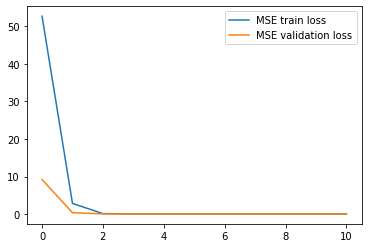

In [41]:
plt.plot(train.history["loss"], label="MSE train loss")
plt.plot(train.history["val_loss"], label="MSE validation loss")
plt.legend()
plt.show()

#### Check the model performance against the country baseline

In [42]:
predicted_mortality = list(map(lambda p: 0.0 if p <= 0.0 else p, model.predict(holdout_X).T[0]))

In [43]:
from sklearn.metrics import mean_squared_error

print(f"The current model performs with an average MSE of {mean_squared_error(holdout_y, predicted_mortality)}.")

The current model performs with an average MSE of 0.00012651787767184406.


In [44]:
predicted_deaths = int(sum(map(lambda d: d * (simulation_df["2018_country_population"][0] / 100000), predicted_mortality)))
observed_deaths = int(simulation_df["Deaths"].tail(1).values[0])
pred_pct_diff = "{:.2f}".format((predicted_deaths / observed_deaths) * 100)

In [45]:
print(f"Predicted vs observed deaths over {len(predicted_mortality)} days: {predicted_deaths} vs {observed_deaths}, {pred_pct_diff}%.")

Predicted vs observed deaths over 63 days: 461 vs 533, 86.49%.


## Run the simulation

In [46]:
counterfactual_mortality = list(map(lambda p: 0.0 if p <= 0.0 else p, model.predict(sim_X).T[0]))

In [47]:
pd.Series(counterfactual_mortality).describe()

count    63.000000
mean      0.011257
std       0.019821
min       0.000000
25%       0.001367
50%       0.001377
75%       0.005050
max       0.066099
dtype: float64

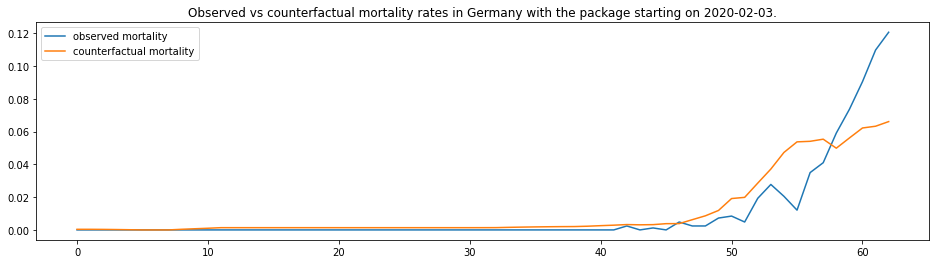

Package contents: Asymptomatic isolation - blanket, Gatherings banned, Public interaction reduction, Nonessential business suspension, School closure


In [48]:
plt.figure(figsize=(16, 4))
plt.plot(sim_y.T[0], label = "observed mortality")
plt.plot(counterfactual_mortality, label = "counterfactual mortality")
plt.legend()
plt.title(f"Observed vs counterfactual mortality rates in {country} with the package starting on {cf_start_date}.")
plt.show()
print(f"Package contents: {', '.join(package)}")

In [49]:
simulation_deaths = int(sum(map(lambda d: d * (simulation_df["2018_country_population"][0] / 100000), predicted_mortality)))
observed_deaths = int(simulation_df["Deaths"].tail(1).values[0])
sim_pct_diff = "{:.2f}".format((simulation_deaths / observed_deaths) * 100)

In [50]:
print(f"Counterfactual vs observed deaths over {len(counterfactual_mortality)} days: {simulation_deaths} vs {observed_deaths}, {sim_pct_diff}%.")

Counterfactual vs observed deaths over 63 days: 461 vs 533, 86.49%.
